# Learning Scikit-learn: Machine Learning in Python

## IPython Notebook for Chapter 2: Supervised Learning - Estimating Boston house pricing using Linear Regression

_In every example we have seen so far, we have faced what in Chapter 1, Machine Learning – A Gentle Introduction, we called classification problems: the output we aimed at predicting belonged to a discrete set. But often, we would want to predict
a value extracted from the real line. In this notebook, we want to approximate a real function (i.e. solve a _regression problem_), using Linear Regression, a very simple regression model, from Scikit-learn._

Start by importing numpy, scikit-learn, and pyplot, the Python libraries we will be using in this chapter. Show the versions we will be using (in case you have problems running the notebooks).

In [42]:
%pylab inline
import IPython
import sklearn as sk
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

print ('IPython version:', IPython.__version__)
print ('numpy version:', np.__version__)
print ('scikit-learn version:', sk.__version__)
print ('matplotlib version:', matplotlib.__version__)

Populating the interactive namespace from numpy and matplotlib
IPython version: 3.2.1
numpy version: 1.9.2
scikit-learn version: 0.16.1
matplotlib version: 1.4.3


`%matplotlib` prevents importing * from pylab and numpy


Import the Boston House Pricing Dataset (http://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html), and show their features.

In [43]:
from sklearn.datasets import load_boston
boston = load_boston()
print (boston.data.shape)
print (boston.feature_names)
print (np.max(boston.target), np.min(boston.target), np.mean(boston.target))
print (boston.DESCR)

(506, 13)
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
50.0 5.0 22.5328063241
Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial hi

Show an example instance, and some common statistics:

In [44]:
print (boston.data[0])
print (np.max(boston.data), np.min(boston.data), np.mean(boston.data))

[  6.32000000e-03   1.80000000e+01   2.31000000e+00   0.00000000e+00
   5.38000000e-01   6.57500000e+00   6.52000000e+01   4.09000000e+00
   1.00000000e+00   2.96000000e+02   1.53000000e+01   3.96900000e+02
   4.98000000e+00]
711.0 0.0 70.0724468258


Build, as usual, training and testing sets:

In [45]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, test_size=0.25, random_state=33)

Before learning, let's try to see which features are more relevant for our learning task, i.e. which of them are better prize predictors. We will use the SelectKBest method from the feature_selection package, and plot the results.

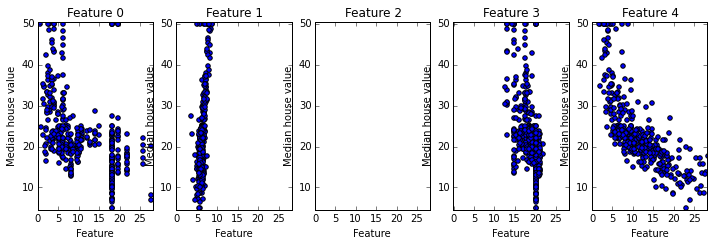

In [46]:
from sklearn.feature_selection import *
fs=SelectKBest(score_func=f_regression,k=5)
X_new=fs.fit_transform(X_train,y_train)
print (zip(fs.get_support(),boston.feature_names))

x_min, x_max = X_new[:,0].min() - .5, X_new[:, 0].max() + .5
y_min, y_max = y_train.min() - .5, y_train.max() + .5
#fig=plt.figure()
#fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# Two subplots, unpack the axes array immediately
fig, axes = plt.subplots(1,5)
fig.set_size_inches(12,12)

for i in range(5):
    axes[i].set_aspect('equal')
    axes[i].set_title('Feature ' + str(i))
    axes[i].set_xlabel('Feature')
    axes[i].set_ylabel('Median house value')
    axes[i].set_xlim(x_min, x_max)
    axes[i].set_ylim(y_min, y_max)
    sca(axes[i])
    plt.scatter(X_new[:,i],y_train)


In regression tasks, is very important to normalize data (to avoid that large-valued features weight too much in the final result)

In [47]:
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler().fit(X_train)
scalery = StandardScaler().fit(y_train)

X_train = scalerX.transform(X_train)
y_train = scalery.transform(y_train)
X_test = scalerX.transform(X_test)
y_test = scalery.transform(y_test)

print (np.max(X_train), np.min(X_train), np.mean(X_train), np.max(y_train), np.min(y_train), np.mean(y_train))


10.2028980046 -4.66702040845 2.47038706385e-15 2.91774920367 -1.93147098641 3.58552238032e-16


### A Linear Model

Let's start with a lineal model, SGDRegressor, that tries to find the hyperplane that minimizes a certain loss function (typically, the sum of squared distances from each instance to the hyperplane). It uses Stochastic Gradient Descent to find the minimum. 

Regression poses an additional problem: how should we evaluate our results? Accuracy is not a good idea, since
we are predicting real values, it is almost impossible for us to predict exactly the final value. There are several measures that can be used (you can look at the list of functions under sklearn.metrics module). The most common is the R2 score, or coefficient of determination that measures the proportion of the outcomes variation explained by the model, and is the default score function for regression methods in scikit-learn. This score reaches its maximum value of 1 when the model perfectly predicts all the test target values. 

In [48]:
from sklearn.cross_validation import *
def train_and_evaluate(clf, X_train, y_train):
    
    clf.fit(X_train, y_train)
    
    print ("Coefficient of determination on training set:",clf.score(X_train, y_train))
    
    # create a k-fold croos validation iterator of k=5 folds
    cv = KFold(X_train.shape[0], 5, shuffle=True, random_state=33)
    scores = cross_val_score(clf, X_train, y_train, cv=cv)
    print ("Average coefficient of determination using 5-fold crossvalidation:",np.mean(scores))

In [49]:
from sklearn import linear_model
clf_sgd = linear_model.SGDRegressor(loss='squared_loss', penalty=None,  random_state=42)
train_and_evaluate(clf_sgd,X_train,y_train)
print (clf_sgd.coef_)

Coefficient of determination on training set: 0.743617732983
Average coefficient of determination using 5-fold crossvalidation: 0.710809853468
[-0.08527595  0.06706144 -0.05032898  0.10874804 -0.07755151  0.38961893
 -0.02485839 -0.20990016  0.08491659 -0.05495108 -0.19854006  0.06126093
 -0.37817963]


You probably noted the $penalty=None$ parameter when we called the method. The penalization parameter for linear regression methods is introduced to avoid overfitting. It does this by penalizing those hyperplanes having some of their coefficients too large, seeking hyperplanes where each feature contributes more or less the same to the predicted value. This parameter is generally the L2 norm (the squared sums of the coefficients) or the L1 norm (that is the sum of the absolute value of the coefficients). Let's see how our model works if we introduce an L2 or L1 penalty.

In [50]:
clf_sgd1 = linear_model.SGDRegressor(loss='squared_loss', penalty='l2',  random_state=42)
train_and_evaluate(clf_sgd1,X_train,y_train)

Coefficient of determination on training set: 0.743616743208
Average coefficient of determination using 5-fold crossvalidation: 0.71081206667


In [51]:
clf_sgd2 = linear_model.SGDRegressor(loss='squared_loss', penalty='l1',  random_state=42)
train_and_evaluate(clf_sgd2,X_train,y_train)

Coefficient of determination on training set: 0.74358692291
Average coefficient of determination using 5-fold crossvalidation: 0.710763609874


### Support Vector Machines for regression

The regression version of SVM can be used instead to find the hyperplane (note how easy is to change the classification method in scikit-learn!). We will try a linear kernel, a polynomial kernel, and finally, a rbf kernel. For more information on kernels, see http://scikit-learn.org/stable/modules/svm.html#svm-kernels

In [52]:
from sklearn import svm
clf_svr= svm.SVR(kernel='linear')
train_and_evaluate(clf_svr,X_train,y_train)

Coefficient of determination on training set: 0.71886923342
Average coefficient of determination using 5-fold crossvalidation: 0.707838419194


In [53]:
clf_svr_poly= svm.SVR(kernel='poly')
train_and_evaluate(clf_svr_poly,X_train,y_train)

Coefficient of determination on training set: 0.904109273301
Average coefficient of determination using 5-fold crossvalidation: 0.779288545488


In [54]:
clf_svr_rbf= svm.SVR(kernel='rbf')
train_and_evaluate(clf_svr_rbf,X_train,y_train)

Coefficient of determination on training set: 0.900132065979
Average coefficient of determination using 5-fold crossvalidation: 0.833662221567


In [55]:
clf_svr_poly2= svm.SVR(kernel='poly',degree=2)
train_and_evaluate(clf_svr_poly2,X_train,y_train)

Coefficient of determination on training set: 0.715338649791
Average coefficient of determination using 5-fold crossvalidation: 0.609837490871


### Random Forests for Regression

Finally, let's try again Random Forests, in their Extra Trees, and Regression version

In [56]:
from sklearn import ensemble
clf_et=ensemble.ExtraTreesRegressor(n_estimators=10,random_state=42)
train_and_evaluate(clf_et,X_train,y_train)

Coefficient of determination on training set: 1.0
Average coefficient of determination using 5-fold crossvalidation: 0.828644680783


An interesting side effect of random forest classification, is that you can measure how 'important' each feature is when predicting the final result (note the number of rooms is the most important). (Thanks to Gareth Williams)

In [57]:
important=zip(clf_et.feature_importances_,boston.feature_names)
print (sorted(important, key=lambda x: x[0], reverse=True))


[(0.34331421222970898, 'RM'), (0.31954983828996342, 'LSTAT'), (0.092736945019823588, 'PTRATIO'), (0.044472308491812683, 'TAX'), (0.034373941865562779, 'DIS'), (0.029049805972639613, 'INDUS'), (0.027707107411758886, 'CRIM'), (0.027504620381606271, 'NOX'), (0.025553479738716051, 'CHAS'), (0.020080334176502228, 'RAD'), (0.017817804117756745, 'B'), (0.01415525490319532, 'AGE'), (0.0036843474009534251, 'ZN')]


Finally, evaluate our classifiers on the testing set

In [58]:
from sklearn import metrics
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True, show_r2_score=False):
    y_pred=clf.predict(X)   
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred)),"\n")

    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y,y_pred),"\n")
        
    if show_confusion_matrix:
        print ("Confusion matrix")
        print (metrics.confusion_matrix(y,y_pred),"\n")
        
    if show_r2_score:
        print ("Coefficient of determination:{0:.3f}".format(metrics.r2_score(y,y_pred)),"\n")

        
measure_performance(X_test,y_test,clf_et, show_accuracy=False, show_classification_report=False,show_confusion_matrix=False, show_r2_score=True)



Coefficient of determination:0.834 

